# Hand Gesture Recognition

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from utilities import load
#from utilities import CNN
#from utilities import display_train_results

import keras

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import merge,Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Conv2DTranspose, \
    UpSampling2D, Activation, LeakyReLU, Flatten, Dropout, GaussianNoise
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.utils import np_utils

import tensorflow

import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import pickle
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data

Reading file  output_im_3.p ...
Reading file  output_im_2.p ...
Reading file  output_im_0.p ...
Reading file  output_lb.p ...
Reading file  output_im_1.p ...
Reading file  output_im_5.p ...
Reading file  output_im_4.p ...
Reading file  output_im_6.p ...
Reading file  output_im_7.p ...


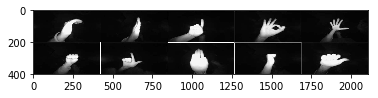

(0.0, 1.0, 0.0, 1.0)

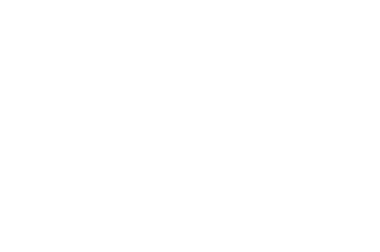

In [6]:
dataa, lb = load()

data = np.array(dataa)
data = data.reshape(-1, 120,120, 1)
labels = np.array(lb)

image = mpimg.imread('dataset.png')
plt.imshow(image)
plt.show()
plt.axis("off")

In [3]:
print('Total number of images: ', data.shape[0])
print('Image size: ', data.shape[1], 'x', data.shape[1])

Total number of images:  40000
Image size:  120 x 120


### Shuffle and separate into train and test

In [4]:
data, labels = shuffle(data, labels, random_state=1)

# 60% train, 20% validation, 20% test
train_data = data[0:32000,:,:,:]
train_labels = labels[0:32000]

val_data = data[32000:36000,:,:,:]
val_labels = labels[32000:36000]

test_data = data[36000:,:,:,:]
test_labels = labels[36000:]

In [5]:
print('Number of training images: ', train_data.shape[0])
print('Number of testing images: ', test_data.shape[0])
print('Number of validation images: ', val_data.shape[0])

Number of training images:  32000
Number of testing images:  4000
Number of validation images:  4000


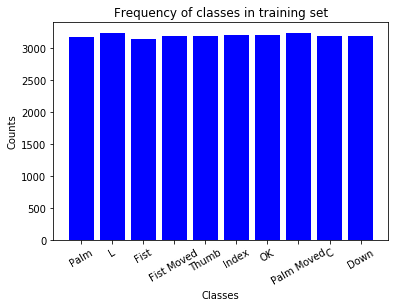

In [71]:
def plot_label_counts(train_labels):
    '''
    plots histogram of label counts
    '''
    unique, counts = np.unique(train_labels, return_counts=True)
    labels = ['Palm','L','Fist','Fist Moved','Thumb','Index','OK','Palm Moved','C','Down']
    
    plt.figure()
    plt.bar(unique,counts,color = 'b',tick_label = labels)
   # plt.xticks(unique,range(len(unique)))
    plt.xticks(rotation = 30)
    plt.ylabel('Counts')
    plt.xlabel('Classes')
    plt.title('Frequency of classes in training set')
    plt.show()

plot_label_counts(train_labels)

### One-hot label encoding

In [6]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_labels = encoder.transform(train_labels)
train_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(val_labels)
encoded_labels = encoder.transform(val_labels)
val_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(test_labels)
encoded_labels = encoder.transform(test_labels)
test_labels_onehot = np_utils.to_categorical(encoded_labels)

### Architecture

In [18]:
def CNN():
    input_img = Input(shape=(120, 120, 1))
    x = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(input_img)
    x = GaussianNoise(0.004)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
#    x = GaussianNoise(0.003)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
 #   x = GaussianNoise(0.003)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
  #  x = GaussianNoise(0.002)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(input_img, output)

#MOST DATA VALUES ARE 0.01 
#0.01 first layer, 0.005 b4 Dropout ===> 0.09
#0.005 first layer ===> 0.912

In [19]:
#parameters
batch_size = 64
epochs = 10
num_classes = 10

In [20]:
my_CNN = CNN()
my_CNN.compile(loss='categorical_crossentropy',  optimizer = RMSprop(), metrics=['accuracy'])

In [21]:
my_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 128)     1280      
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 120, 120, 128)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 60, 64)        256       
__________

### Train

In [22]:
my_CNN_train = my_CNN.fit(train_data, train_labels_onehot, batch_size=batch_size,epochs=epochs,\
                                    verbose=1,validation_data=(val_data, val_labels_onehot))

Train on 32000 samples, validate on 4000 samples
Epoch 1/10
32000/32000 [==============================] - 103s 3ms/step - loss: 0.3941 - acc: 0.8879 - val_loss: 0.0811 - val_acc: 0.9802
Epoch 2/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0499 - acc: 0.9856 - val_loss: 0.0144 - val_acc: 0.9970
Epoch 3/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0318 - acc: 0.9919 - val_loss: 6.1454 - val_acc: 0.5015
Epoch 4/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0271 - acc: 0.9939 - val_loss: 0.4272 - val_acc: 0.9285
Epoch 5/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0232 - acc: 0.9951 - val_loss: 0.7363 - val_acc: 0.8705
Epoch 6/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0215 - acc: 0.9951 - val_loss: 7.0854 - val_acc: 0.4863
Epoch 7/10
32000/32000 [==============================] - 102s 3ms/step - loss: 0.0133 - acc: 0.9971 - val_loss: 0.9989 - v

In [23]:
my_CNN.save('my_CNN.h5')

### Training results

<Figure size 720x720 with 0 Axes>

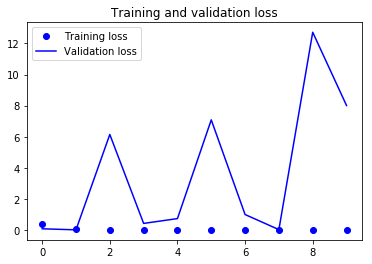

In [24]:
loss = my_CNN_train.history['loss']
val_loss = my_CNN_train.history['val_loss']
epochs = range(10)
fig = plt.figure(figsize=(10, 10))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Visualize layers

In [65]:
layer_outputs = [layer.output for layer in my_CNN.layers]
activation_model = Model(inputs=my_CNN.input, outputs=layer_outputs)
img = 0
activations = activation_model.predict(train_data[img].reshape(1,120,120,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig = plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
   # plt.title('Output of layer'+str(act_index))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

Text(0.5,1,'Output of layer1')

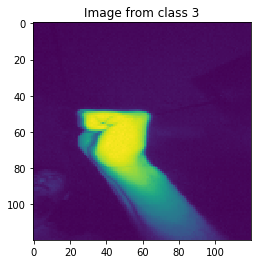

<Figure size 720x720 with 0 Axes>

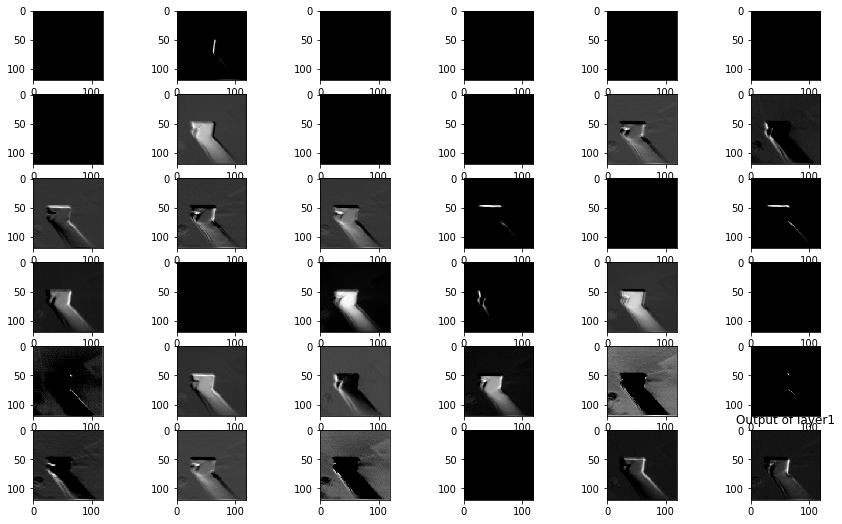

In [67]:
plt.imshow(train_data[img][:,:,0]);
plt.title('Image from class ' + str(train_labels[img]))
layer = 1 #+1
display_activation(activations, 6, 6, layer)


### Evaluate on test set

In [25]:
loss, acc = my_CNN.evaluate(test_data, test_labels_onehot, batch_size=batch_size, verbose=0)

In [26]:
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 7.702045509338379
Test accuracy: 0.461


### Predict using test set

In [27]:
predicted_classes = my_CNN.predict(test_data)

In [28]:
predicted = predicted_classes.argmax(axis=1)
print('predicted:', predicted)
print('ground truth:',(test_labels))

predicted: [1 1 1 ... 1 4 1]
ground truth: [5 0 0 ... 1 4 1]


### Results

Found 1844 correct labels


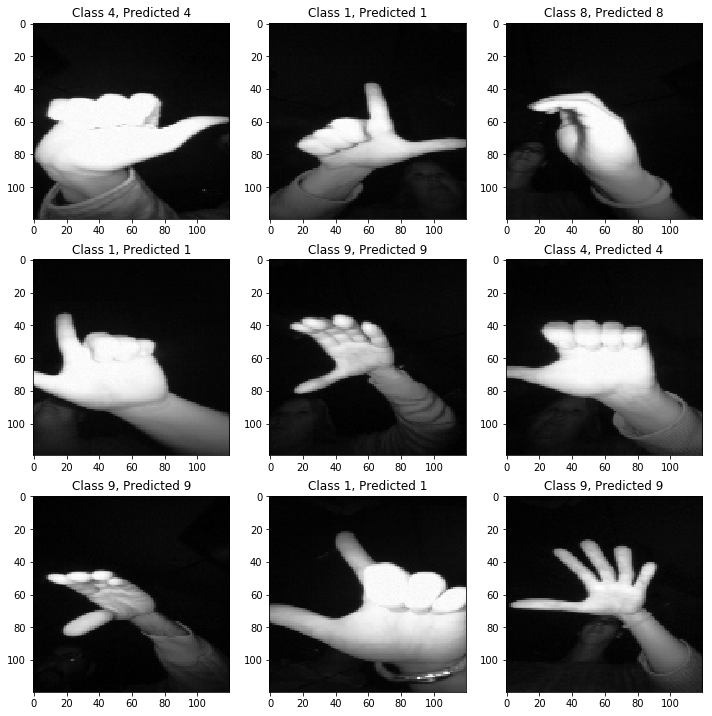

In [29]:
correct = np.where(predicted==test_labels)[0]
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels_onehot.shape

print('Found %d correct labels' %len(correct))
fig = plt.figure(figsize=(10, 10))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Class {}, Predicted {}".format(test_labels[correct],predicted_classes[correct]))
    plt.tight_layout()

Found 2157 incorrect labels


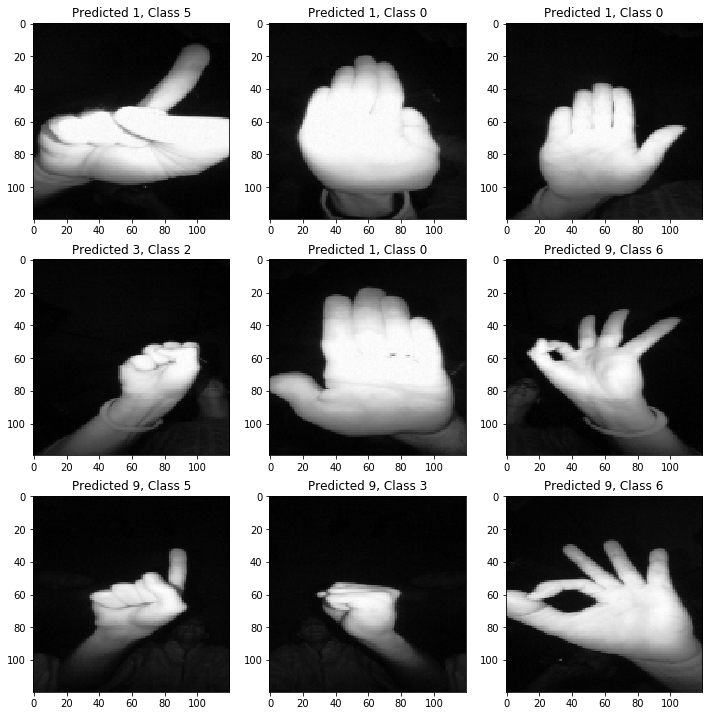

In [30]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print('Found %d incorrect labels' % len(incorrect))
fig = plt.figure(figsize=(10, 10))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

In [31]:
confusion_matrix = metrics.confusion_matrix(y_true=test_labels, y_pred=predicted_classes)

Text(0.5,1,'Normalized Confusion Matrix')

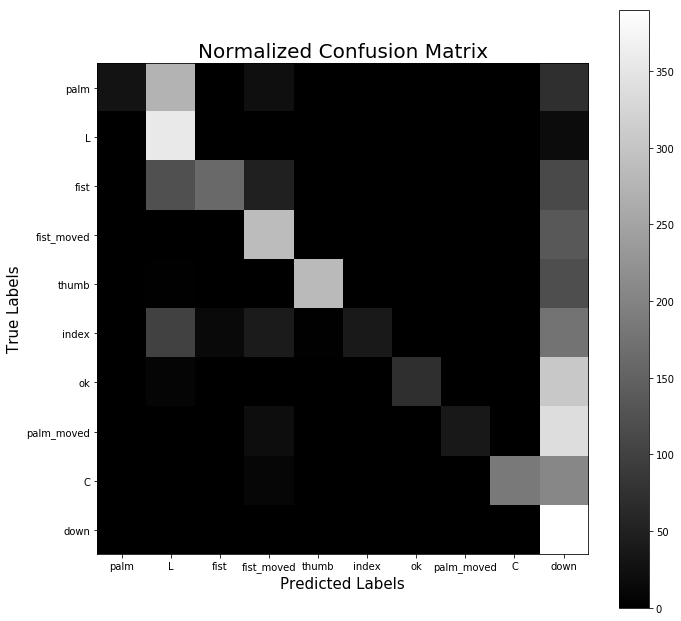

In [32]:
classes = {0: 'palm',
           1: 'L',  
           2: 'fist',     
           3: 'fist_moved', 
           4: 'thumb',      
           5: 'index',     
           6: 'ok',        
           7: 'palm_moved', 
           8: 'C',         
           9: 'down'  
              }
fig = plt.figure(figsize=(11, 11))
plt.imshow(confusion_matrix, cmap='gray')
plt.xticks(np.arange(10), list(classes.values()))
plt.xlabel("Predicted Labels", fontsize=15)
plt.yticks(np.arange(10), list(classes.values()))
plt.ylabel("True Labels", fontsize=15)
plt.colorbar()
plt.title("Normalized Confusion Matrix", fontsize=20)

### Classification Report

In [33]:
target_names = ['palm','L','fist','fist_moved','thumb', \
                'index','ok','palm_moved','C','down']
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

        palm       0.94      0.08      0.14       399
           L       0.41      0.95      0.57       374
        fist       0.92      0.36      0.52       448
  fist_moved       0.67      0.68      0.67       423
       thumb       0.99      0.70      0.82       406
       index       1.00      0.10      0.19       376
          ok       1.00      0.19      0.31       387
  palm_moved       1.00      0.09      0.17       395
           C       1.00      0.46      0.63       402
        down       0.21      1.00      0.34       390

   micro avg       0.46      0.46      0.46      4000
   macro avg       0.81      0.46      0.44      4000
weighted avg       0.82      0.46      0.44      4000

